In [17]:
from matplotlib import pyplot as plt
from scipy.optimize import fmin_l_bfgs_b
from keras.layers import Reshape
import numpy as np
import helper
from glob import glob
import os
from keras import backend as K
import tensorflow as tf
#![ -e face_gen_little_deeper.h5 ] || gdown 'https://drive.google.com/uc?id=1n69owNHxXa8N-w4G6rClTOOwQsLdfuQn' -O face_gen_little_deeper.h5

In [18]:
from keras.models import load_model
AM = load_model('face_gen_little_deeper.h5')

In [19]:
Gen = AM.get_layer("generator")

In [20]:
input_shape = Gen.input_shape[1]

## Face at 0

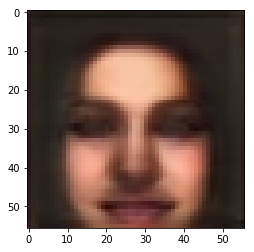

In [21]:
middle = K.zeros(shape=(1, input_shape)) 
i = Gen.predict(middle, steps=1)
middle_face = helper.image_for_plot(i) # wrrr, use it!
plt.imshow(middle_face[0])

## Face 1

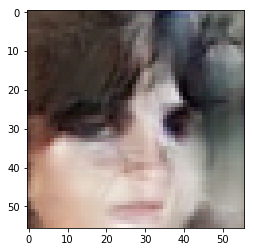

In [22]:
noise = K.random_normal_variable((1, input_shape), 0, 0.5)
i = Gen.predict(noise, steps=1)
im = helper.image_for_plot(i)
plt.imshow(im[0])

## Face 2

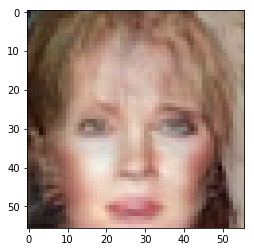

In [30]:
noise2 = K.random_normal_variable((1, input_shape), 0, 0.5)
i2 = Gen.predict(noise2, steps=1)
im2 = helper.image_for_plot(i2)
plt.imshow(im2[0])

## Face 1 + Face 2

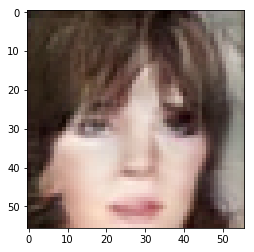

In [31]:
noise3 = (noise + noise2) / 2
i3 = Gen.predict(noise3, steps=1)
im3 = helper.image_for_plot(i3)
plt.imshow(im3[0])

## Scaling down the generator input noise

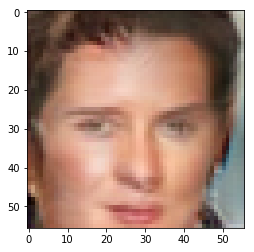

In [36]:
noise4 = K.random_normal_variable((1, input_shape), 0, 0.5)
i = Gen.predict(noise4, steps=1)
im = helper.image_for_plot(i)
plt.imshow(im[0])

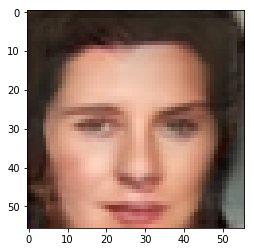

In [37]:
noiser = noise4 * 0.5
i = Gen.predict(noiser, steps=1)
im = helper.image_for_plot(i)
plt.imshow(im[0])

## GAN Reverse

In [38]:
def gan_reverse(i, steps = 50):
    z = np.random.normal(0, 0.5, size = [1, input_shape])
    x = K.placeholder()
    loss = K.sum(K.square(i - Gen.outputs[0]))
    grad = K.gradients(loss, Gen.inputs[0])[0]
    update_fn = K.function(Gen.inputs, [loss, grad])

    def eval_loss_and_grad(z, j):
        l, g = update_fn([z.reshape(1, input_shape), j])
        return l.astype('float64'), g.astype('float64')

    for step in range(steps):
        j = Gen.predict(z, steps=1)
        f = lambda x: eval_loss_and_grad(x, j)
        z, min_val, _ = fmin_l_bfgs_b(f, z, maxfun=20)
        z = z.reshape(1, input_shape)
        
        if step % 5 == 0:
            print("Step:", step)
    return z

Step: 0
Step: 5


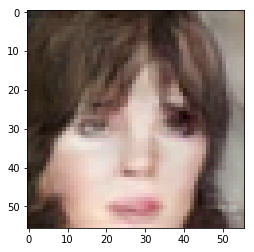

In [39]:
z = gan_reverse(i3, steps=6)
j = Gen.predict(z, steps=1)
j = helper.image_for_plot(j)
plt.imshow(j[0])

In [40]:
im_dir = glob(os.path.join('.', 'linda.jpg'))[0]
image1 = helper.get_image(im_dir, 'RGB', helper.celeba_preprocessing, width=56,  height=56, \
                          face_size=330, delta_i=-35, delta_j=-10, rotation=6)
images = [image1, middle_face[0]]
plt.imshow(helper.images_grid_for_plot(images, 'RGB', 2, 1))

IndexError: list index out of range

In [45]:
z1 = gan_reverse(image1 / 255 - 0.5, steps = 32)
j1 = Gen.predict(z1, steps=1)
plt.imshow(helper.image_for_plot(j1[0]))

NameError: name 'image1' is not defined

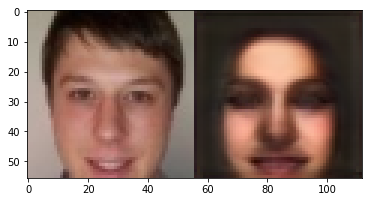

In [42]:
#please add papieża polaka naszego rodaka wielką osobę to repository
im_dir = glob(os.path.join('.', 'jch.jpg'))[0]
image2 = helper.get_image(im_dir, 'RGB', helper.celeba_preprocessing, width=56,  height=56, \
                           face_size=90, delta_i=-13, delta_j=0)
images = [image2, middle_face[0]]
plt.imshow(helper.images_grid_for_plot(images, 'RGB', 2, 1))

Step: 0
Step: 5
Step: 10
Step: 15
Step: 20
Step: 25
Step: 30


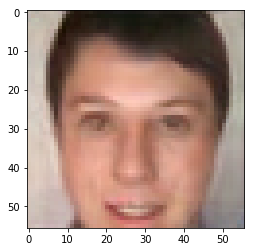

In [43]:
z2 = gan_reverse(image2 / 255 - 0.5, steps = 32)
j2 = Gen.predict(z2, steps=1)
plt.imshow(helper.image_for_plot(j2[0]))

In [44]:
plt.imshow(helper.image_for_plot(j1[0]))

NameError: name 'j1' is not defined

In [46]:
j3 = Gen.predict((z1 *5 + z2 *5) / 10, steps=1)
plt.imshow(helper.image_for_plot(j3[0]))

NameError: name 'z1' is not defined

(1680, 1680, 3)


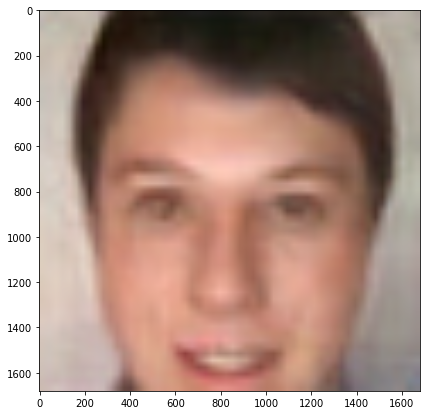

(1680, 1680, 3)


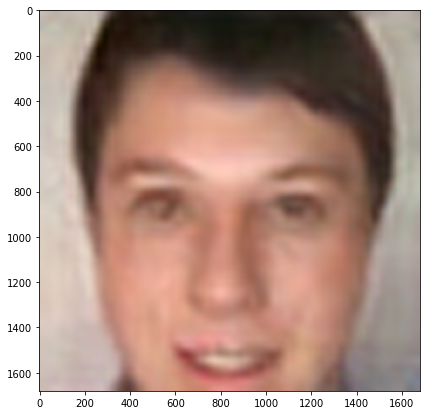

error: OpenCV(4.0.0) C:\projects\opencv-python\opencv\modules\imgcodecs\src\loadsave.cpp:661: error: (-2:Unspecified error) could not find a writer for the specified extension in function 'cv::imwrite_'


In [113]:
import math
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import uuid
import sys
%matplotlib inline

savePath = "images/"

my_dpi = 240

def countPi(i, M, N):
    return 1 + (i - 1)*(M - 1)/(N - 1)

def interval(k, M):
    if k == M:
        return M - 1 
    else:
        return math.floor(k)

def linearSpline(v, N):
    M = len(v)
    newV = np.array(N)
    linFuncs = []
    
    for i in range(0, M):
        a = v[i + 1] - v[i]
        b = v[i]
        f = lambda x : a*(x - 1) + b
        linFuncs.append(f)
    end

    for i in range(0, N):
        p_i = countPi(i, M, N)
        fp_i = interval(p_i, M)

        # create linear function between [i, i+1]
        f = linFuncs[fp_i]
        newV[i] = math.round(f(p_i))
    end

    return newV

def cubicSpline(v, N):
    M = len(v) - 1
    b = np.array(M)
    d = np.array(M)
    a = np.array(M)

    for i in range(1, M):
        a[i] = 3.0*(v[i + 1] - 2*v[i] + v[i - 1])
    end

    c = np.array(M + 1)
    l = np.array(M + 1)
    u = np.array(M + 1)
    z = np.array(M + 1)

    l[1] = 1.0
    u[1] = z[1] = 0.0
    for i in range(1, M):
        l[i] = 4.0 - u[i - 1]
        u[i] = 1.0 / l[i]
        z[i] = (a[i] - z[i - 1]) / l[i]
    end

    l[M + 1] = 1.0
    z[M + 1] = c[M + 1] = 0.0

    for j in range(M, -1, -1):
        c[j] = z[j] - u[j] * c[j + 1]
        b[j] = v[j + 1] - v[j] - (c[j + 1] + 2*c[j]) / 3.0
        d[j] = (c[j + 1] - c[j]) / 3.0
    end

    spline = []
    for i in range(1, M):
        spline.append(lambda x : v[i] +
                b[i]*(x - i) +
                c[i]*(x - i)^2 +
                d[i]*(x - i)^3)
    end

    M = M + 1
    newV = np.array(N)

    for i in range(0, N):
        p_i = countPi(i, M, N)
        fp_i = interval(p_i, M)

        f = spline[fp_i]
        newV[i] = max(0, min(255, math.round(f(p_i))))
    end
    return newV

def showimg(img):
    h, w = img.shape[:2]
    print(img.shape)
    #img2 = img[:,:,::-1]
    plt.rcParams['figure.figsize'] = [h/my_dpi, w/my_dpi]
    #plt.autoscale(False)
    plt.imshow(img, cmap='gray')
    plt.show()
    
def scaleimg(img, x, y, func):
    return cv.resize(img, None, fx=x, fy=y, interpolation = func)
    
def randstring():
    return str(uuid.uuid4())[:8]

(1680, 1680, 3)


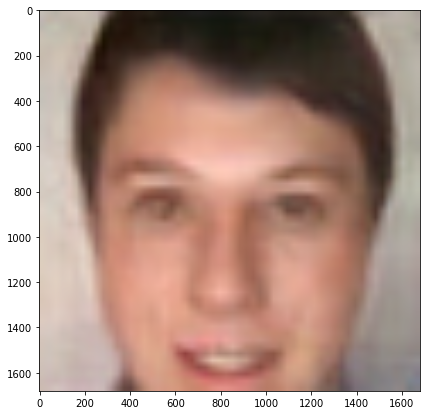

(1680, 1680, 3)


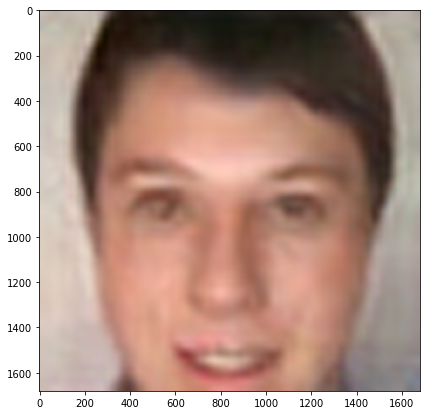

In [114]:
[img] = helper.image_for_plot(j2)
res = scaleimg(img, 30, 30, cv.INTER_LINEAR)
res2 = scaleimg(img, 30, 30, cv.INTER_CUBIC)

showimg(res)
showimg(res2)

#path = savePath + randstring()
#cv.imwrite(path + "_linear.png", res)
#cv.imwrite(path + "_cubic.png", res2)